# Imports

In [1]:
import numpy as np
import laspy
from pandas import DataFrame
from geopandas import GeoDataFrame
from shapely.geometry import Point

In [2]:
file_path = "output/USGS_LPC_TX_South_B8_2018_LAS.las"

In [3]:
# Read LAS file
las = laspy.read(file_path)

# Import LAS into numpy array (X=raw integer value x=scaled float value)
# lidar_points = np.array((las.x,
#                         las.y,
#                         las.z,
#                         las.intensity,
#                         las.raw_classification,
#                         las.scan_angle_rank)).transpose()

# # Transform to pandas DataFrame
# lidar_df = DataFrame(lidar_points)

# # Transform to geopandas GeoDataFrame
# crs = None
# geometry = [Point(xyz) for xyz in zip(las.x, las.y, las.z)]
# lidar_geodf = GeoDataFrame(lidar_df, crs=crs, geometry=geometry)
# lidar_geodf.crs = {'init': 'epsg:2959'}  # set correct spatial reference


In [19]:
las.x.array[:100].shape

(100,)

In [5]:
las.header

<LasHeader(1.2, <PointFormat(3, 0 bytes of extra dims)>)>

In [6]:
# lidar_geodf

# Try visualizing

In [14]:
import numpy as np
import laspy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


In [8]:
point_records = las.points.copy()

In [9]:
# dir(point_records)

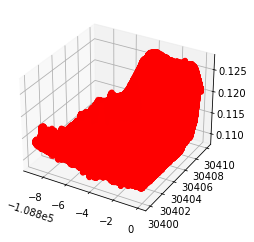

In [15]:
# getting scaling and offset parameters
las_scaleX = las.header.scale[0]
las_offsetX = las.header.offset[0]
las_scaleY = las.header.scale[1]
las_offsetY = las.header.offset[1]
las_scaleZ = las.header.scale[2]
las_offsetZ = las.header.offset[2]

# calculating coordinates
p_X = np.array((las.x * las_scaleX) + las_offsetX)
p_Y = np.array((las.y * las_scaleY) + las_offsetY)
p_Z = np.array((las.z * las_scaleZ) + las_offsetZ)

# plotting points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p_X, p_Y, p_Z, c='r', marker='o')
plt.show()

# With Plotly

In [5]:
import plotly.express as px

In [12]:
fig = px.scatter_3d(x=p_X[:10000], y=p_Y[:10000], z=p_Z[:10000])
fig.show()

In [12]:
p_X.shape

(3010943,)